### KNN
Regression based on k-nearest neighbors.

The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

One thing to note KNN wont require any transformation so we are opting power transformation here!

In [1]:
# lets import some dependencies

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import validation_curve

from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# loading our data
df = pd.read_csv("./Data/data.csv",sep=",")
df.drop(['Unnamed: 0'], axis=1, inplace=True) # There were some formatting issues while
                                              # writing the csv

In [3]:
df.head()

,DISTRICT,UPAZILA,STATION_ID,STATION_NAME,DATE,RAIN_FALL(mm),LATITUDE,LONGITUDE,WATER_LEVEL(m)
0,Bandarban,Lama,CL317,Lama,01-jan-2017,0.0,21.81,92.19,6.22
1,Bandarban,Lama,CL317,Lama,02-jan-2017,0.0,21.81,92.19,6.22
2,Bandarban,Lama,CL317,Lama,03-jan-2017,0.0,21.81,92.19,6.22
3,Bandarban,Lama,CL317,Lama,04-jan-2017,0.0,21.81,92.19,6.21
4,Bandarban,Lama,CL317,Lama,05-jan-2017,0.0,21.81,92.19,6.21


Defining our X and y

In [4]:
X = df['RAIN_FALL(mm)'].values.reshape(-1,1) # input feature
y = df['WATER_LEVEL(m)'].values.reshape(-1,1) # target feature

In [5]:
X.shape, y.shape

((1826, 1), (1826, 1))

Making the train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=17, shuffle=True
)

#### Model Building

Initialize our CV

In [7]:
kflod = KFold(n_splits=5,shuffle=True, random_state=17)

Initialize the KNN model with default parameters
- n_neighbors: 5
- weights: uniform
- algorithm: auto
- leaf_size: 30
- p: 2 (power parameter of Minkowski metric)
- metric: minkowski
- metric_params: None

In [8]:
knn =  KNeighborsRegressor(n_jobs=-1)

As usual, lets first check our CV scores with the default parameters!

In [9]:
results = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=kflod,
    scoring='neg_mean_absolute_error'
)
-results.mean()

0.4486728767123287

Note:
- This is better than our linear models!

Checking for train-test accuracy

In [10]:
knn.fit(X_train,y_train)

KNeighborsRegressor(n_jobs=-1)

In [11]:
# accuracy on the train set
knn_pred = knn.predict(X_train)
mean_absolute_error(y_train,knn_pred)

0.3863758904109589

In [12]:
# accuracy on the test set
knn_pred = knn.predict(X_test)
mean_absolute_error(y_test,knn_pred)

0.4345224043715846

#### Learning Curve
Lets plot the learning curve to see how our dataset's size influence the model accuracy

In [13]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [14]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        knn,X,y, train_sizes=train_sizes,cv=kflod,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

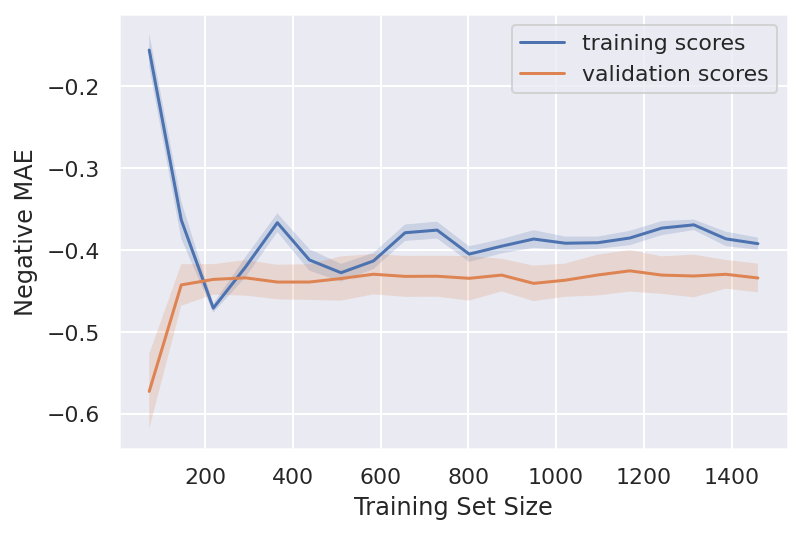

In [15]:
plot_learning_curve()

Note:
- From this we conlude, adding more data to this stage, wont help us to improve the model!

#### Validation Curves

In [16]:
# helper function
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [17]:
def plot_validation_curve(param_grid,param,estimator):
    val_train, val_test = validation_curve(
    estimator=estimator,
    X=X_train,
    y=y_train,
    param_name=param,
    param_range=param_grid,
    cv=kflod,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
    )

    plot_with_err(param_grid, val_train, label="training scores")
    plot_with_err(param_grid, val_test, label="validation scores")
    plt.xlabel(param)
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

- **Number of Neighbors**

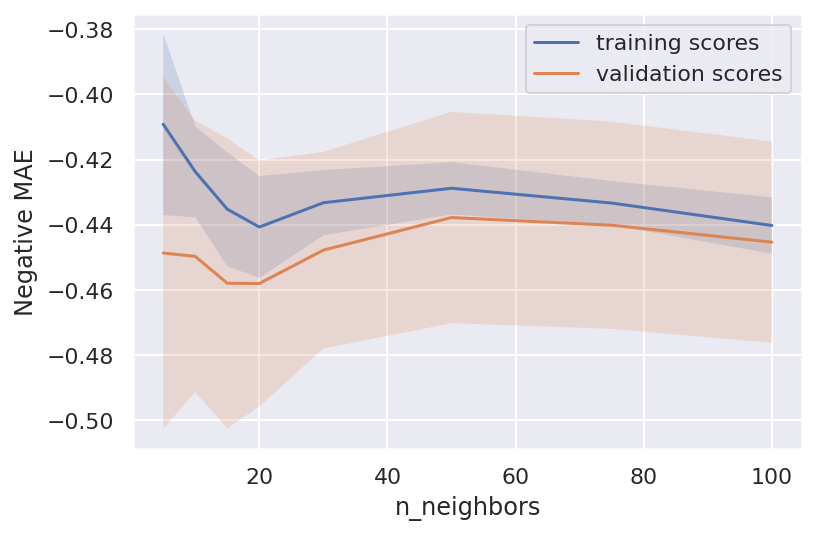

In [18]:
plot_validation_curve([5, 10, 15, 20, 30, 50, 75, 100],'n_neighbors',knn)

from figure its clear that the optimal range for number of neighbors is between 40 to 60

- **weights**

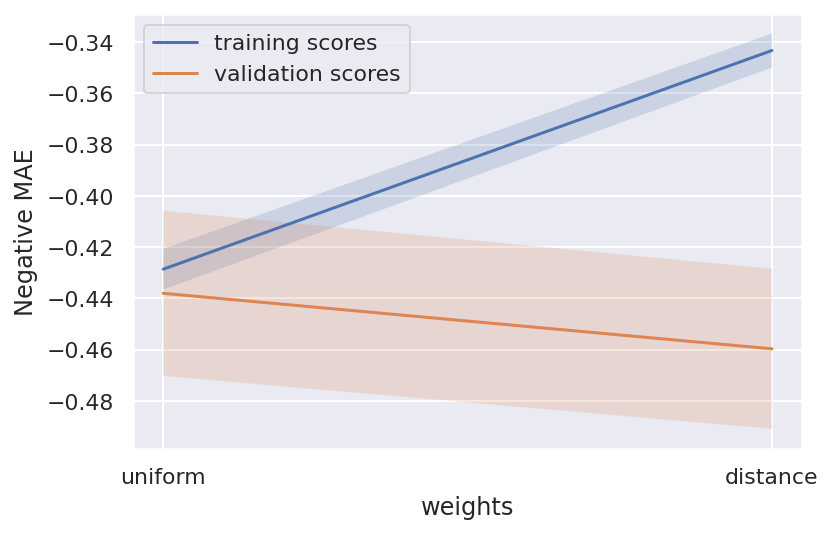

In [19]:
knn = KNeighborsRegressor(n_neighbors=45,n_jobs=-1)
plot_validation_curve(['uniform','distance'],'weights',knn)

There will be higher variance in the model if we use distance as our weights!

- **algorithm**

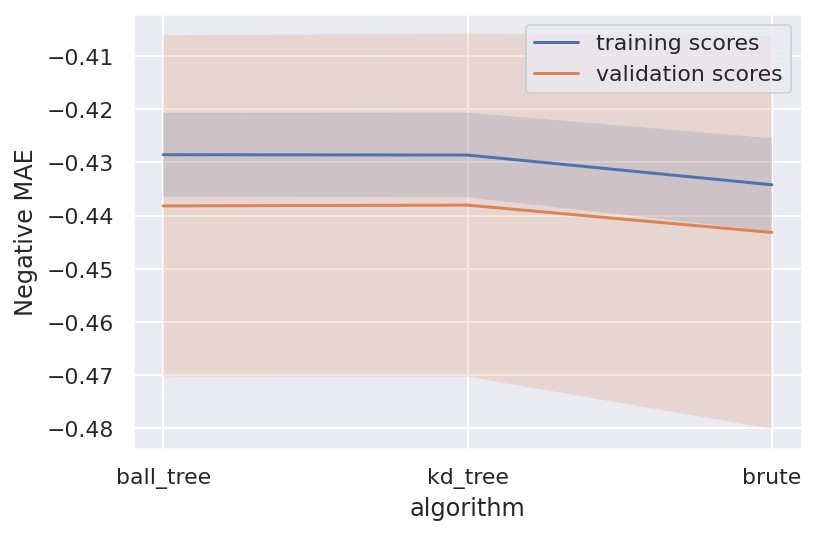

In [20]:
plot_validation_curve(['ball_tree','kd_tree','brute'],'algorithm',knn)

there's no significant distance in algorithms

- **leaf size**

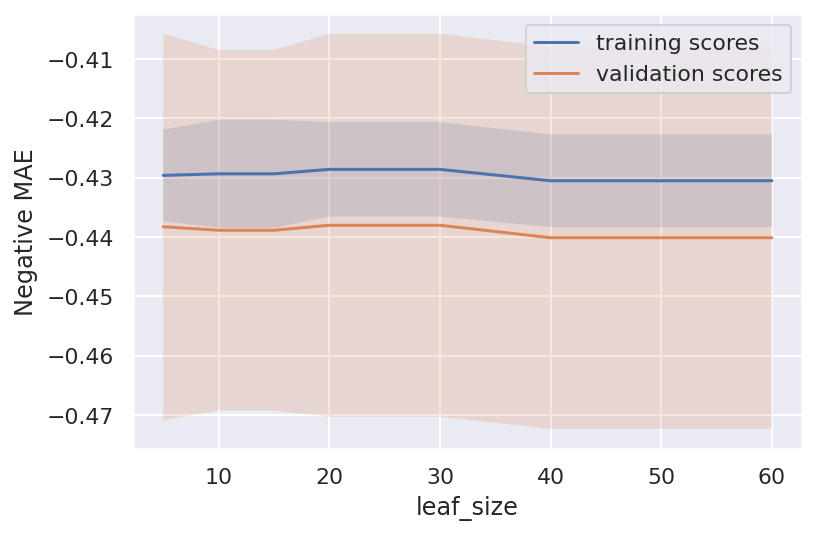

In [21]:
knn = KNeighborsRegressor(n_neighbors=45,algorithm='kd_tree',n_jobs=-1)
plot_validation_curve([5,10,15,20,30,40,50,60],'leaf_size',knn)

No siginficant difference here too

- **p**

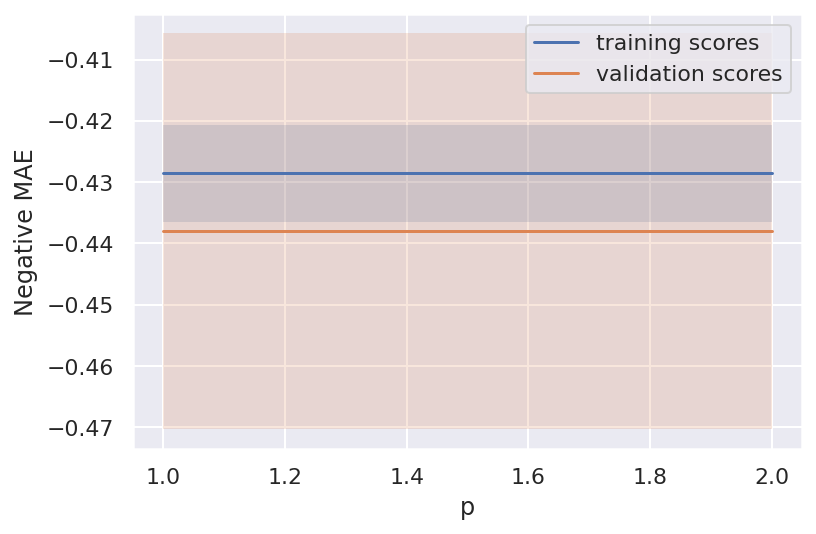

In [22]:
plot_validation_curve([1,2],'p',knn)

doesnt matter which norm we use!

#### Hyper Parameter Tuning
Based on the knowledge of the validation curves we plotted lets do the hyperparameter tuning of KNN in order to find the best model!

In [23]:
knn_params = {
    'n_neighbors':[40,45,50,55,60],
    'algorithm': ['ball_tree','kd_tree'],
    'weights':['uniform','distacne']
}
knn = KNeighborsRegressor(n_jobs=-1)
gcv = GridSearchCV(knn,knn_params,n_jobs=-1,cv=kflod,verbose=1,\
    scoring='neg_mean_absolute_error')


In [24]:
# training the model
gcv.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
             estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': [40, 45, 50, 55, 60],
                         'weights': ['uniform', 'distacne']},
             scoring='neg_mean_absolute_error', verbose=1)

In [25]:
# the best score in CV
gcv.best_score_

-0.4377368493150685

In [26]:
# the best estimator
gcv.best_estimator_

KNeighborsRegressor(algorithm='ball_tree', n_jobs=-1, n_neighbors=50)

In [27]:
# the best parameters
gcv.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'uniform'}

Lets check the train-test accuracy of our best estimator

In [28]:
# accuracy on train set
knn_pred = gcv.best_estimator_.predict(X_train)
mean_absolute_error(y_train,knn_pred)

0.42500967123287675

In [29]:
# accuracy on the test set
knn_pred = gcv.best_estimator_.predict(X_test)
mean_absolute_error(y_test,knn_pred)

0.422436174863388

**Final Note**
- Theres little to none overfitting occuring here
- we have significantly increase the accuracy of our model to .42 meters!

#### Learning Curve

In [30]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        gcv.best_estimator_,X_train,y_train, \
        train_sizes=train_sizes,cv=kflod,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

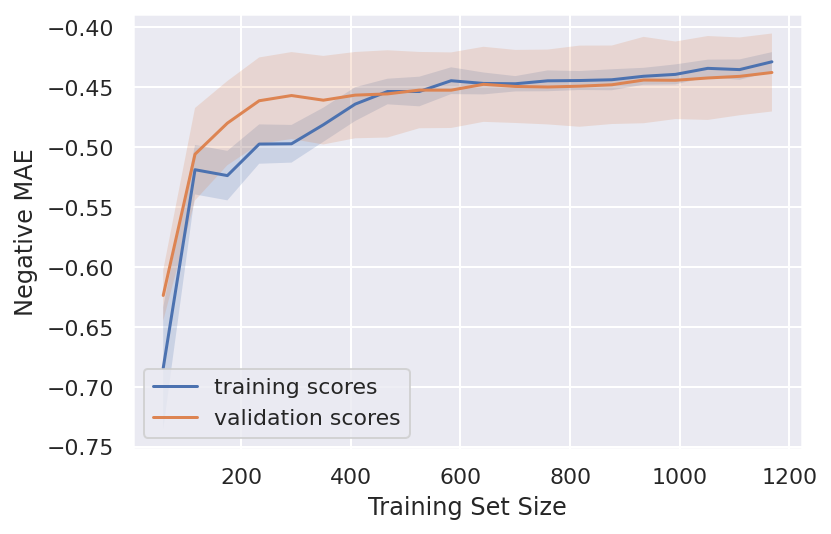

In [31]:
plot_learning_curve()